<a href="https://colab.research.google.com/github/mcnica89/MATH4060/blob/main/Gamblers_Problem_SARSA_and_GRAD_descent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#Import packages. Feel free to add any others you might use!
import itertools
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from jax import random as jrandom
from jax import nn as jnn
import random
import time
import math
import numpy as np

In [2]:
#Code these as global variables to match textbook notation for inputs to functions
P_HEADS = 0.3
N_TARGET = 100
N_PARAMS = 10

# The exact answer using value iteration

We will compare our answer to this answer

Iteration number:  0


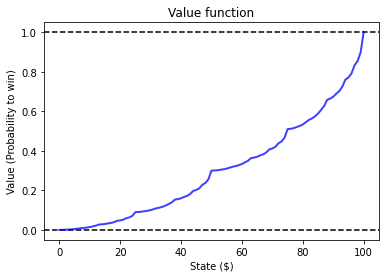

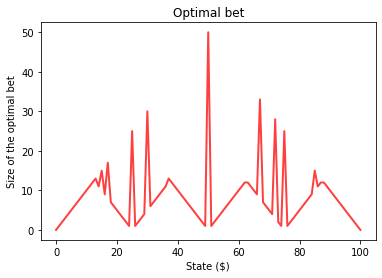

In [16]:
def plot_value_function_and_actions_v(v_star, a_star):
  #Purpose:
  #  Plot v_star and a_star for the Gambler's problem
  #Output:
  #  A plot of the simple random walks 


  fig, ax = plt.subplots()  # Create a figure containing a single axes.
  ax.axhline(0,color='black',linestyle='dashed')
  ax.axhline(1,color='black',linestyle='dashed')
  ax.set_title("Value function")
  ax.set_xlabel("State ($)")
  ax.set_ylabel("Value (Probability to win)")

  #ax.set(ylim=(-2*math.sqrt(N_steps),2*math.sqrt(N_steps)))

  #print("Generating random walks....")
  #random_walks = generate_simple_random_walk(random_key,N_steps,N_samples)
  #print("Plotting random walks....")
  ax.plot(v_star,linewidth=2, alpha=0.75, color='blue')  # Plot some data on the axes.
  
  fig2, ax2 = plt.subplots()  # Create a figure containing a single axes.
  ax2.set_title("Optimal bet")
  ax2.set_xlabel("State ($)")
  ax2.set_ylabel("Size of the optimal bet")


  ax2.plot(a_star,linewidth=2, alpha=0.75, color='red')  # Plot some data on the axes.

  plt.show()


def gamblers_problem_matrix(p_heads,N_target):
  '''return a matrix for what happesn int the gamblers problems'''
  P = np.zeros((N_target+1,N_target+1,N_target+1))
  #P(i,j,a) is the probabilty to go from state i to state j when you bet a
  i,j,a = np.indices(P.shape)
  first_row = (i==0)
  last_row = (i==N_target)
  first_or_last_row = np.logical_or(first_row,last_row)
  inbetween_row = np.logical_not(first_or_last_row)
  maximum_bet_size_ok = np.logical_and(a<=i, a<=N_target-i)
  allowed_to_bet = np.logical_and(inbetween_row, maximum_bet_size_ok)
  P[np.logical_and(i+a==j, allowed_to_bet)] = p_heads 
  P[np.logical_and(i-a==j, allowed_to_bet)] = 1-p_heads
  P[np.logical_and(i==j,np.logical_not(allowed_to_bet))] = 1
  return P

def gamblers_problem(p_heads, N_target, num_iters=10, loops=False):
  '''Given the gamblers problem, find the optimal value function v_star 
     and the optimal action a_star at any given state s'''

  v_star = np.zeros(N_target+1) #An array with the optimal values
  v_star[N_target] = 1 #Initialize known values at s=N_target and s=0
  v_star[0] = 0 

  a_star = np.zeros(N_target+1) #An array with the optimal betting size
  #The s-th component represent the value at s

  q_star = np.zeros((N_target+1,N_target+1))
  #q_star(s,a) is the value function if you play action a from state s
  # and then play optimally afterwards
  # The s-th, a-th etnry of q_star represents q_star(s,a)
  # Be careful! q_star(s,a) only makes sense if a is less than max_bet at s
  # Max_bet(s) = min(s,N_target-s)

  P = gamblers_problem_matrix(p_heads,N_target)

  for iteration in range(num_iters):
    if iteration % 100 == 0:
      print("Iteration number: ", iteration)
    
    if not loops:
      q_star = np.einsum( 'sja,j->sa' ,P,v_star)
      v_star = np.max(q_star,axis=1)
      a_star = np.argmax(q_star,axis=1)
    else:
    #Loop way:
    #plot_value_function_and_actions(v_star,a_star)
      for s in range(0,N_target): #Loop through all states
        max_bet = np.minimum(s, N_target-s )
        for a in range(1,max_bet+1): #Loop through all allowed actions
          q_star[s,a] = p_heads*v_star[s+a] + (1-p_heads)*v_star[s-a]
          v_star[s] = np.max(q_star[s,:])
          a_star[s] = np.argmax(q_star[s,:])

  plot_value_function_and_actions_v(v_star,a_star)
  return v_star, a_star

V_TRUE, A_TRUE = gamblers_problem(P_HEADS, N_TARGET, 100)

# Explanation of the value function setup

First we think of a function $f:[0,1] \to [0,1]$ by thinking in terms of the fraction of the way to the end, $f(x)=v(x N_{TARGET},w)$ for $x\in [0,1]$. We want $f$ to have these properties (which we basically invented):
- Piecewise linear
- Has $f(0)=0$, $f(N_{TARGET})=1$ 
- Has slope equal to the $i$-th weight, $w[i]$ on the interval $[i/N_{PARAMS}, (i+1)/N_{PARAMS}]$ 

This is achieved as follows:
- Do linear combinations of the functions $(x - i/N_{PARAMS})^+$ i.e.

 $$ f(x) = \sum_{i=1}^{N_{PARAMS}} d_i (x - i/N_{PARAMS})^+ $$

 where we only add on the terms where $x - i/N_{PARAMS} > 0$ (We use the notation $x^+ = x$ if $x>0$ and $x^+ = 0$ if $x<0$. This is alo called the RELU function $ReLU(x)=x^+$) 

 Here $d_i$ represents the slope ADDED to the function in the $i$-th interval. Since we want the weights to be the slope (and not the amount added on) we set $d_i = w_{i+1} - w_{i}$. Lastly, we normalize everything so that the average slope is 1 so that the function will end at $f(1)=1$. This can be achived by replacing $w$ with $w/mean(w)$

In [4]:
FEATURE_LOCATIONS = jnp.arange(0,1,1.0/N_PARAMS) #Location of the intervals for the piecewise linear function
print("Locations: ", FEATURE_LOCATIONS)

@jax.jit
def two_condition_where(cond1, val1, cond2, val2, val_else ): #Used to make sure out of range things are set correctly
  return jnp.where( cond1, val1, jnp.where(cond2, val2, val_else))

@jax.jit
def value_func(s,w): 
  '''Represents the value function at state s using weights w'''
  x = s/N_TARGET #x \in [0,1] is the "fraction" we are done
  
  if jnp.isscalar(s):  
    #The features are a vector of length "FEATURE_LOCATIONS" where the i-th compnent is
    #    (x - LOCATION_i)^+ 
    # This is implemented using the relu function relu(x)=x^+
    features = jnn.relu(x- FEATURE_LOCATIONS) 
  else:
    #When x is a vector, we use broadcasting to calculate all the featuers at once 
    # So features will be an array of shape (length of x, length of FEATURE_LOCATIONS)  
    features = jnn.relu(x[:,jnp.newaxis] - FEATURE_LOCATIONS) 
  
  #By doing a sum of the features, we are adding to the slope at each interval
  # Since we want the weights w to represent the slope (not the change in slope)
  # we do a difference of the weights w first
  # We also normalize so that the average slope is 1. This ensures that f(1)=1
  normalized_slope_diffs = jnp.diff(w,prepend=0)/jnp.mean(w) 
  
  score = jnp.inner(  features, normalized_slope_diffs ) 

  #We clip the score so its always between [0,1] (this matters e.g. in case negative slopes crop up)
  clipped_score = jnp.clip(score,0.0,1.0)

  #We also ensure that situations where s<0 and s>N_TARGET are handled correctly using the jnp.where statement
  return two_condition_where( s<=0, 0.0, s>=N_TARGET, 1.0, clipped_score )

@jax.jit
def q_func(s,a,w):
  '''Value of the q function at state s and action a, using the weights w'''

  #We use the fact that taking action a moves you up to states s+a with probability P_HEADS
  # and down to state s-a with probability 1-P_HEADS. 
  # This means we can write the q function in terms of just the value function 
  ans = P_HEADS*value_func( s+a, w ) + (1-P_HEADS)*value_func( s-a, w )

  #We also ensure cases where s<=0 and s>=N_TARGET are handled correctly
  return two_condition_where( s<=0, 0.0, s>=N_TARGET, 1.0, ans) 

#Take the gradient of both! 
#Note that the second number tells jax.grad which variable to take the derivative w.r.t to
grad_value_func = jax.grad(value_func, 1)
grad_q_func = jax.grad(q_func, 2)


#Function tests!
s = N_TARGET/2
w = jnp.ones(N_PARAMS)
print("Value func test: ", value_func(s,w))

a = 1
print("Q func test: ", q_func(s,a,w))

#Batch test:
s = jnp.array([N_TARGET/4, N_TARGET/2, N_TARGET*2, 0])
print("Batch value func test: ", value_func(s,w))

#Gradient tests:
s = N_TARGET/2
grad_value_func = jax.grad(value_func, 1)
print("Gradient of value function test: ", grad_value_func(s,w))

s = N_TARGET/2
a = 1
grad_q_func = jax.grad(q_func, 2)
print("Gradient of Q function test: ", grad_q_func(s,a, w))

Locations:  [0.         0.1        0.2        0.3        0.4        0.5
 0.6        0.7        0.8        0.90000004]
Value func test:  0.5
Q func test:  0.496
Batch value func test:  [0.25 0.5  1.   0.  ]
Gradient of value function test:  [ 0.05        0.05        0.05000003  0.05        0.05       -0.04999999
 -0.04999999 -0.04999999 -0.04999999 -0.04999999]
Gradient of Q function test:  [ 0.05040002  0.05040001  0.05040001  0.0504      0.04339998 -0.0466
 -0.04959999 -0.04959999 -0.04959999 -0.04959999]


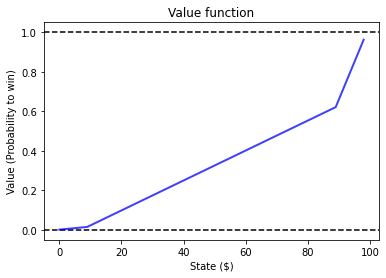

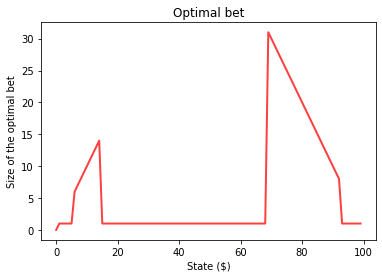

In [6]:
import numpy as np
def plot_value_function_and_actions(w, autoscale=True):
  #Purpose:
  #  Plot v_star and a_star for the Gambler's problem
  #Output:
  #  A plot of the simple random walks 


  fig, ax = plt.subplots()  # Create a figure containing a single axes.
  if autoscale:
    ax.axhline(0,color='black',linestyle='dashed')
    ax.axhline(1,color='black',linestyle='dashed')
  ax.set_title("Value function")
  ax.set_xlabel("State ($)")
  ax.set_ylabel("Value (Probability to win)")

  
  a_star = np.zeros(N_TARGET)
  all_states = jnp.arange(1,N_TARGET)
  v_star = value_func(all_states,w)
    
  for s in range(1,N_TARGET):
    max_bet = min(s,N_TARGET-s)
    all_bets = jnp.arange(1,max_bet+1)
    q_s = q_func(s,all_bets,w)
    a_star[s] = jnp.argmax(q_s)+1 #add one because the "0"-th entry represents betting 1
    


  ax.plot(v_star,linewidth=2, alpha=0.75, color='blue')  # Plot some data on the axes.

  fig2, ax2 = plt.subplots()  # Create a figure containing a single axes.
  ax2.set_title("Optimal bet")
  ax2.set_xlabel("State ($)")
  ax2.set_ylabel("Size of the optimal bet")

  ax2.plot(a_star,linewidth=2, alpha=0.75, color='red')  # Plot some data on the axes.

  plt.show()

w = jnp.ones(N_PARAMS)
w = w.at[0].set(0.2) #lower the slope of the first segment 
w = w.at[-1].set(5.0) #increase the slope of the last segment
plot_value_function_and_actions(w)

In [21]:
@jax.jit
def RMS(x):
  return jnp.mean(jnp.square(x))

def gamblers_problem_epsilon_greedy(s, w, epsilon):
  '''Return the action dertermined from the q function from current_state using the epsilon-greedy algorthm'''
  #This sis the line from the pseudocode that says "Choose A from S using policy derived from Q (e.g. epsilond greedy)"
  if s == 0 or s==N_TARGET:
    return 1 #Handles the corner case when max_bet would be 0


  probability_epsilon_event = (random.random() < epsilon)

  #Compute the greedy action by finding all the q values and maximizing
  max_bet =  min(s,N_TARGET-s)
  all_bets = jnp.arange(1,max_bet+1)
  q_s = q_func(s,all_bets,w)
  greedy_action = int(jnp.argmax(q_s)+1)

  #Implement epsilon-greedy: 
  # -Completly random with probability epsilon (or if we have some kind of out of bound sitatuion)
  # -Otherwise choose the greedy action
  if greedy_action == 0 or greedy_action > max_bet or probability_epsilon_event == True:  
    return random.randint(1,max_bet) #Purely random
  else:
    return greedy_action #Purely greedy

def gamblers_problem_nextstate(current_state, action):
  '''Returns the next state (its random!) given the current_state and action you chose'''

  win = (random.random() < P_HEADS) #Boolean if you won or not
  if win == True:
    return current_state + action
  else:
    return current_state - action 

def gamblers_problem_SARSA_grad(num_episodes=10):
  w = jnp.ones(N_PARAMS) #initialize the weights
  RMS_history = np.zeros(num_episodes)
  #Loop over all the episodes
  for episode in range(num_episodes):

    #Display progress 10 times during the run
    if episode % int(num_episodes/10) == 0:
      w = w/jnp.mean(w) #Normalize the weights to have average slope 1
      #(This doesnt change anything since the value func normalizes them anyways)
      print("Iteration number: ", episode)
      print("Weights: ",w)

    #On a new epsiodes, set the epsilon value and learning rate and pick a random starting state  
    epsilon = 10/jnp.sqrt(episode+1)
    learning_rate = 10/jnp.sqrt(episode+1)
    current_state = random.randint(1,N_TARGET-1)


    #Loop until we exit
    while current_state > 0 and current_state < N_TARGET:
      
      #Get the action and q value according to epsilon greedy
      current_action = gamblers_problem_epsilon_greedy(current_state, w, epsilon)
      q_current = q_func(current_state,current_action,w)

      #Find the gradient here! Used in the update rule
      grad = grad_q_func(current_state,current_action,w)

      #Get the next state and next action again using the policy and advancement
      new_state = gamblers_problem_nextstate(current_state, current_action)
      new_action = gamblers_problem_epsilon_greedy(new_state, w, epsilon)
      q_new = q_func(new_state,new_action,w)
     
      #Updat the weights according to gradient descent!
      w = w + learning_rate*(q_new - q_current)*grad

      #Update the state and then repeat
      current_state = new_state
    
    #Compare our answer so far to the true answer and record it
    all_states = jnp.arange(0,N_TARGET+1)
    v_star = value_func(all_states,w)
    RMS_history[episode] = RMS(v_star - V_TRUE)
  
  plot_value_function_and_actions(w)
  fig3, ax3 = plt.subplots()  # Create a figure containing a single axes.
  ax3.set_title("RMS eror History")
  ax3.set_xlabel("Iteration")
  ax3.set_ylabel("RMS distance to optimal")

  ax3.plot(RMS_history,linewidth=2, alpha=0.75, color='black')  # Plot some data on the axes.

  plt.show()
  return w

Iteration number:  0
Weights:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Iteration number:  1000
Weights:  [-0.23  0.09  0.57  0.73  0.91  0.68  0.71  0.97  1.67  3.9 ]
Iteration number:  2000
Weights:  [-0.15  0.16  0.63  0.76  0.95  0.65  0.74  0.9   1.51  3.84]
Iteration number:  3000
Weights:  [-0.01  0.29  0.72  0.77  0.95  0.65  0.71  0.8   1.34  3.77]
Iteration number:  4000
Weights:  [-0.05  0.19  0.56  0.64  0.95  0.7   0.75  0.84  1.37  4.05]
Iteration number:  5000
Weights:  [0.01 0.24 0.54 0.66 0.97 0.67 0.72 0.8  1.3  4.08]
Iteration number:  6000
Weights:  [-0.    0.23  0.53  0.64  1.    0.72  0.74  0.79  1.25  4.11]
Iteration number:  7000
Weights:  [0.03 0.25 0.6  0.7  1.04 0.69 0.69 0.74 1.18 4.07]
Iteration number:  8000
Weights:  [-0.01  0.19  0.49  0.62  1.04  0.71  0.73  0.76  1.2   4.27]
Iteration number:  9000
Weights:  [0.04 0.2  0.48 0.61 1.07 0.73 0.74 0.74 1.14 4.25]


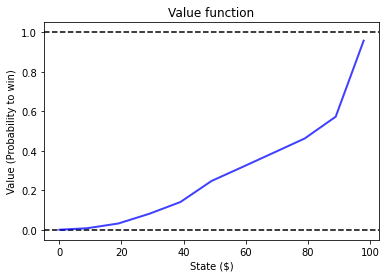

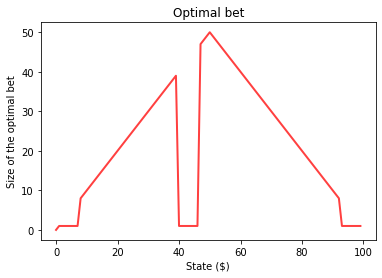

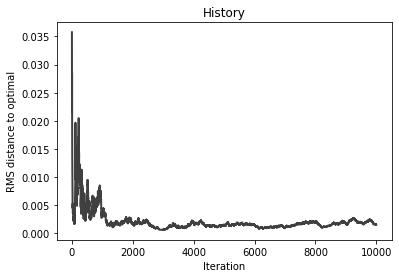

DeviceArray([0.09, 0.24, 0.49, 0.59, 1.06, 0.71, 0.72, 0.72, 1.1 , 4.27],            dtype=float32)

In [23]:
jnp.set_printoptions(precision=2, suppress=True)
gamblers_problem_SARSA_grad(10000)